In [80]:
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
df = pd.read_csv('dataset/llm/train_essays.csv')
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [7]:
df_prompts = pd.read_csv('dataset/llm/train_prompts.csv')
df_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [4]:
# dataset comprises of 1375 human-written texts, only 3 ai-generated
df['generated'].value_counts()

0    1375
1       3
Name: generated, dtype: int64

In [5]:
df['prompt_id'].value_counts()

0    708
1    670
Name: prompt_id, dtype: int64

In [8]:
df.duplicated().any()

False

In [9]:
df.isnull().any()

id           False
prompt_id    False
text         False
generated    False
dtype: bool

In [10]:
df_human = df[df['generated'] == 0]
df_ai = df[df['generated'] == 1]
print(df_human.info())
df_ai.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1375 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1375 non-null   object
 1   prompt_id  1375 non-null   int64 
 2   text       1375 non-null   object
 3   generated  1375 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 53.7+ KB
None


,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [128]:
def tokenize_and_clean_text(text):
    tokens = tokenize.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    punct_chars = string.punctuation + "'s" + '""' + '...' + "''" + '``'
    filtered_tokens = [word.lower() for word in tokens if word not in stop_words and word not in punct_chars]
    return filtered_tokens

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def get_mean_sent_char_length(sent_tokens):
    return np.mean([len(sent) for sent in sent_tokens])

def get_mean_sent_word_length(sent_tokens):
    return np.mean([len(sent.split()) for sent in sent_tokens])

In [13]:
df['BoW_raw'] = df['text'].apply(tokenize_and_clean_text)

In [16]:
df['text_length'] = df['BoW_raw'].apply(lambda x: len(x))

In [42]:
df['average_word_length'] = df['BoW_raw'].apply(lambda x: np.mean([len(word) for word in x if word.isalpha()]))

In [27]:
pd.options.display.float_format = '{:,.2f}'.format

In [29]:
print(df['text_length'].min())
print(df['text_length'].max())
print(df['text_length'].mean())

119
925
314.7699564586357


In [30]:
df['text_sent_length'] = df['text'].apply(tokenize.sent_tokenize).apply(len)

In [129]:
df['mean_sentence_length_chars'] = df['text'].apply(tokenize.sent_tokenize).apply(get_mean_sent_char_length)

In [130]:
df['mean_sentence_length_words'] = df['text'].apply(tokenize.sent_tokenize).apply(get_mean_sent_word_length)

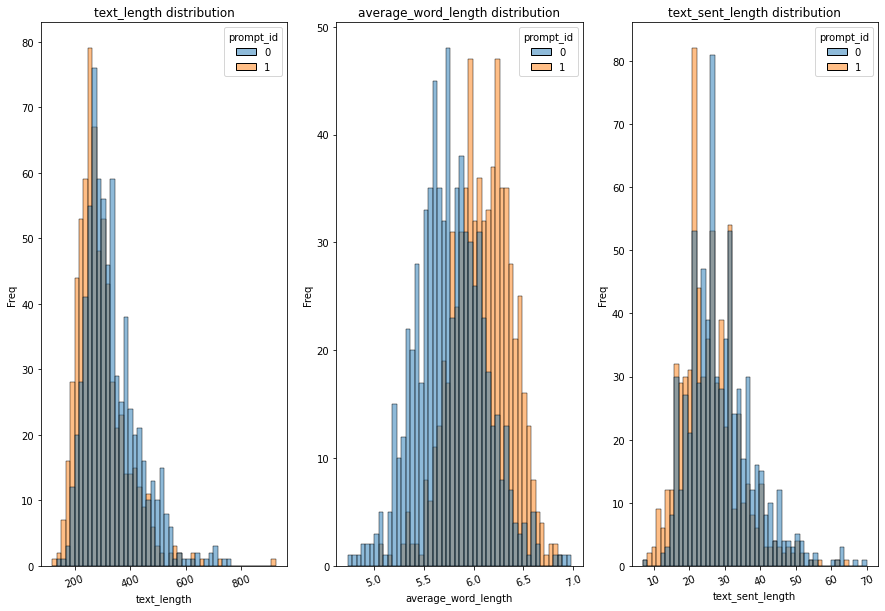

In [33]:
num_cols = df[['text_length', 'average_word_length', 'text_sent_length']].columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='prompt_id', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

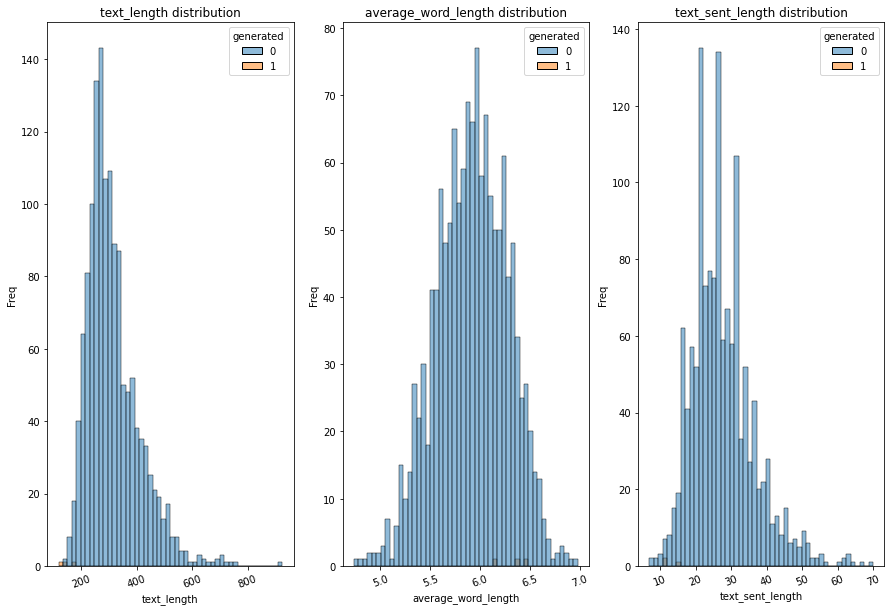

In [34]:
# Only 3 texts were generated :(
num_cols = df[['text_length', 'average_word_length', 'text_sent_length']].columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [37]:
cnt = Counter()
df['BoW_raw'].apply(lambda x: ''.join(x)).apply(cnt.update)
cnt

Counter({'c': 113491,
         'a': 192683,
         'r': 164132,
         's': 180863,
         'o': 178711,
         'u': 72541,
         'n': 166461,
         'd': 85469,
         'i': 177794,
         'e': 352389,
         'b': 28559,
         'm': 58644,
         'f': 30961,
         '1': 2652,
         '9': 990,
         '0': 4677,
         'h': 56941,
         'y': 44694,
         't': 202956,
         'l': 146462,
         'p': 77096,
         'j': 2488,
         'v': 40594,
         'g': 72154,
         'q': 1298,
         'w': 35912,
         'k': 18697,
         'z': 2349,
         'x': 4033,
         '2': 2755,
         '5': 1606,
         '3': 1513,
         '7': 802,
         "'": 3799,
         '6': 939,
         '.': 1590,
         '4': 889,
         '8': 562,
         ',': 420,
         ':': 21,
         '_': 16})

In [41]:
df['BoW_lemmatized'] = df['BoW_raw'].apply(lemmatize)

In [111]:
df['tokens_num'] = df['BoW_lemmatized'].apply(len)

In [50]:
cnt_lemm = Counter()
df['BoW_lemmatized'].apply(cnt_lemm.update)
lemm_unigramms = cnt_lemm.most_common()
lemm_unigramms

[('car', 11614),
 ('vote', 8529),
 ('electoral', 7234),
 ('people', 7056),
 ('college', 6145),
 ('state', 5971),
 ('the', 5109),
 ('would', 3942),
 ('president', 3782),
 ('elector', 2883),
 ('in', 2800),
 ("n't", 2753),
 ('candidate', 2663),
 ('one', 2651),
 ('election', 2516),
 ('usage', 2457),
 ('many', 2420),
 ('i', 2398),
 ('popular', 2289),
 ('city', 2243),
 ('get', 2198),
 ('way', 2147),
 ('day', 2144),
 ('this', 2096),
 ('also', 2073),
 ('even', 2059),
 ('pollution', 2007),
 ('voter', 1892),
 ('system', 1889),
 ('source', 1814),
 ('driving', 1800),
 ('le', 1785),
 ('it', 1750),
 ('voting', 1739),
 ('smog', 1647),
 ('use', 1644),
 ('air', 1615),
 ('could', 1603),
 ('make', 1569),
 ('time', 1549),
 ('world', 1535),
 ('limiting', 1524),
 ('go', 1509),
 ('much', 1482),
 ('gas', 1467),
 ('like', 1465),
 ('country', 1379),
 ('want', 1312),
 ('percent', 1309),
 ('say', 1307),
 ('take', 1292),
 ('environment', 1275),
 ('a', 1252),
 ('transportation', 1250),
 ('citizen', 1222),
 ('place'

In [115]:
cnt_lemm.most_common(20)

[('car', 11614),
 ('vote', 8529),
 ('electoral', 7234),
 ('people', 7056),
 ('college', 6145),
 ('state', 5971),
 ('the', 5109),
 ('would', 3942),
 ('president', 3782),
 ('elector', 2883),
 ('in', 2800),
 ("n't", 2753),
 ('candidate', 2663),
 ('one', 2651),
 ('election', 2516),
 ('usage', 2457),
 ('many', 2420),
 ('i', 2398),
 ('popular', 2289),
 ('city', 2243)]

In [89]:
unigrams = {key: value for key, value in lemm_unigramms}
unigrams

{'car': 11614,
 'vote': 8529,
 'electoral': 7234,
 'people': 7056,
 'college': 6145,
 'state': 5971,
 'the': 5109,
 'would': 3942,
 'president': 3782,
 'elector': 2883,
 'in': 2800,
 "n't": 2753,
 'candidate': 2663,
 'one': 2651,
 'election': 2516,
 'usage': 2457,
 'many': 2420,
 'i': 2398,
 'popular': 2289,
 'city': 2243,
 'get': 2198,
 'way': 2147,
 'day': 2144,
 'this': 2096,
 'also': 2073,
 'even': 2059,
 'pollution': 2007,
 'voter': 1892,
 'system': 1889,
 'source': 1814,
 'driving': 1800,
 'le': 1785,
 'it': 1750,
 'voting': 1739,
 'smog': 1647,
 'use': 1644,
 'air': 1615,
 'could': 1603,
 'make': 1569,
 'time': 1549,
 'world': 1535,
 'limiting': 1524,
 'go': 1509,
 'much': 1482,
 'gas': 1467,
 'like': 1465,
 'country': 1379,
 'want': 1312,
 'percent': 1309,
 'say': 1307,
 'take': 1292,
 'environment': 1275,
 'a': 1252,
 'transportation': 1250,
 'citizen': 1222,
 'place': 1218,
 'paris': 1213,
 'united': 1212,
 'help': 1185,
 'life': 1170,
 'if': 1147,
 'may': 1126,
 'without': 1

In [47]:
def get_words_as_text(tokens):
    return ' '.join(tokens)

In [71]:
words = df['BoW_raw'].apply(get_words_as_text)
words_as_texts = ' '.join(words)
all_words = words_as_texts.split()

In [94]:
bigrams = nltk.ngrams(all_words, 2)
cnt_bigrams = Counter(bigrams)
bigr = cnt_bigrams.most_common()

In [93]:
bigrams_freq = {' '.join(key): value for key, value in bigr}
bigrams_freq

{'electoral college': 5792,
 'car usage': 1996,
 'popular vote': 1732,
 'the electoral': 1354,
 'united states': 1172,
 'limiting car': 1148,
 'electoral votes': 689,
 'vote president': 652,
 'without cars': 536,
 'air pollution': 531,
 'many people': 525,
 'use cars': 506,
 'greenhouse gas': 447,
 'source 2': 408,
 'gas emissions': 394,
 'public transportation': 373,
 'source 3': 370,
 'carfree day': 358,
 'elect president': 328,
 'college unfair': 321,
 'swing states': 319,
 "i 'm": 308,
 'electors vote': 306,
 'source 1': 304,
 'much happier': 297,
 'car use': 297,
 'for example': 294,
 'slate electors': 284,
 'popular votes': 284,
 '60 percent': 274,
 'college system': 269,
 'election popular': 268,
 'usage cars': 264,
 'always tense': 261,
 'advantages limiting': 259,
 'vauban germany': 258,
 'in conclusion': 253,
 'take away': 253,
 'electoral vote': 250,
 'driving ban': 245,
 'away stress': 243,
 'using cars': 241,
 'happier way': 239,
 'around world': 237,
 'elisabeth rosenthal

In [97]:
trigrams = nltk.ngrams(all_words, 3)
cnt_trigrams = Counter(trigrams)
trigr = cnt_trigrams.most_common()

In [96]:
trigrams_freq = {' '.join(key): value for key, value in trigr}
trigrams_freq

{'the electoral college': 1272,
 'limiting car usage': 1010,
 'greenhouse gas emissions': 327,
 'electoral college unfair': 306,
 'electoral college system': 263,
 'election popular vote': 247,
 'much happier way': 233,
 'advantages limiting car': 229,
 'take away stress': 226,
 "'m much happier": 222,
 "i 'm much": 220,
 'president united states': 217,
 "tense i 'm": 211,
 'always tense i': 210,
 'indefensible electoral college': 202,
 'car i always': 200,
 'i always tense': 199,
 'the indefensible electoral': 199,
 'i car i': 192,
 'partial driving ban': 190,
 'opportunity take away': 190,
 'good opportunity take': 188,
 'electoral college why': 181,
 'lower air pollution': 181,
 'percent greenhouse gas': 180,
 'stress lower air': 179,
 'suburb life goes': 175,
 'away stress lower': 175,
 'when i car': 174,
 'college why even': 174,
 'limit car usage': 172,
 'german suburb life': 171,
 'in german suburb': 170,
 'paris bans driving': 167,
 'driving due smog': 165,
 'passenger cars res

In [83]:
def get_pos(tokens):
    return [tag for word, tag in nltk.pos_tag(tokens, lang='eng')]

In [85]:
cnt_pos = Counter()
df['BoW_raw'].apply(get_pos).apply(cnt_pos.update)
pos_count = cnt_pos.most_common()
pos_count

[('NN', 128895),
 ('JJ', 68366),
 ('NNS', 56489),
 ('RB', 28083),
 ('VBP', 24130),
 ('VBG', 21259),
 ('VB', 15621),
 ('IN', 15426),
 ('VBD', 12632),
 ('CD', 11268),
 ('DT', 10529),
 ('VBZ', 9691),
 ('MD', 8085),
 ('VBN', 7182),
 ('PRP', 4347),
 ('JJR', 3888),
 ('RBR', 1775),
 ('WRB', 1121),
 ('CC', 1015),
 ('JJS', 1010),
 ('RP', 493),
 ('TO', 479),
 ('WP', 408),
 ('PRP$', 373),
 ('WDT', 329),
 ('EX', 276),
 ('FW', 136),
 ('RBS', 133),
 ('NNP', 113),
 ('PDT', 53),
 ('POS', 52),
 ('NNPS', 25),
 ('$', 23),
 ('WP$', 21),
 ('UH', 20),
 ('SYM', 6),
 ("''", 1)]

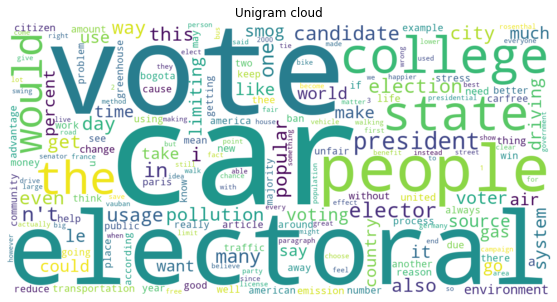

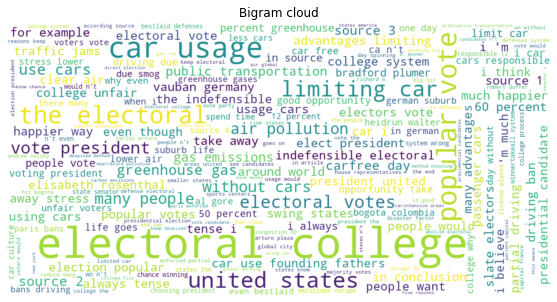

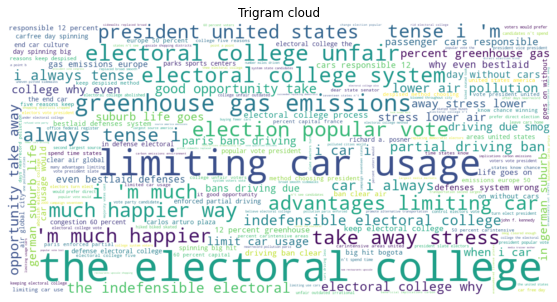

In [105]:
frequencies = unigrams, bigrams_freq, trigrams_freq
for feature in frequencies:
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(feature)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if feature == unigrams:
        plt.title('Unigram cloud')
    elif feature == bigrams_freq:
        plt.title('Bigram cloud')
    else:
        plt.title('Trigram cloud')
    plt.axis('off')
    plt.show()

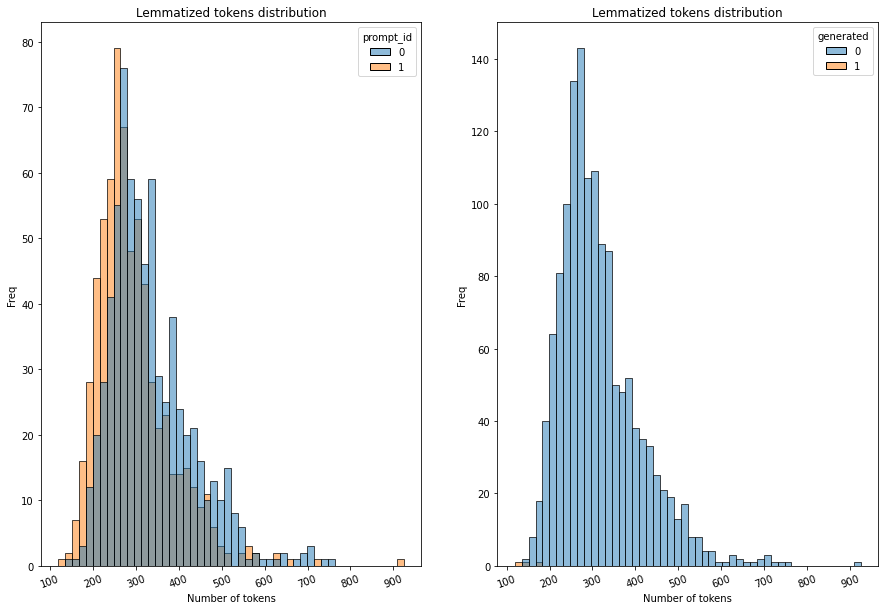

In [113]:
cols = ['prompt_id', 'generated']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), cols):
    sns.histplot(data=df, x=df['tokens_num'], hue=col, ax=ax, bins=50)
    ax.set_title('Lemmatized tokens distribution')
    ax.set_xlabel(f'Number of tokens')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [131]:
df

,id,prompt_id,text,generated,BoW_raw,text_length,average_word_length,text_sent_length,BoW_lemmatized,tokens_num,mean_sentence_length_chars,mean_sentence_length_words
0,0059830c,0,Cars. Cars have been around since they became ...,0,"[cars, cars, around, since, became, famous, 19...",337,5.70,23,"[car, car, around, since, became, famous, 1900...",337,141.91,25.39
1,005db917,0,Transportation is a large necessity in most co...,0,"[transportation, large, necessity, countries, ...",277,6.22,27,"[transportation, large, necessity, country, wo...",277,100.30,17.11
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,"[america, love, affair, vehicles, seems, cooli...",441,6.25,48,"[america, love, affair, vehicle, seems, coolin...",441,91.19,15.50
3,00940276,0,How often do you ride in a car? Do you drive a...,0,"[how, often, ride, car, do, drive, one, motor,...",413,5.88,47,"[how, often, ride, car, do, drive, one, motor,...",413,84.36,14.60
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,"[cars, wonderful, thing, they, perhaps, one, w...",511,5.45,50,"[car, wonderful, thing, they, perhaps, one, wo...",511,92.92,17.42
...,...,...,...,...,...,...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0,"[there, fuss, elector, college, many, people, ...",226,5.94,30,"[there, fuss, elector, college, many, people, ...",226,79.10,14.33
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0,"[limiting, car, usage, many, advantages, such,...",199,5.29,17,"[limiting, car, usage, many, advantage, such, ...",199,120.82,23.35
1375,ffa247e0,0,There's a new trend that has been developing f...,0,"[there, new, trend, developing, years, soon, f...",445,6.02,36,"[there, new, trend, developing, year, soon, fu...",445,119.47,20.81
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0,"[as, know, cars, big, part, society, today, ho...",323,5.17,31,"[a, know, car, big, part, society, today, howe...",323,89.55,16.94


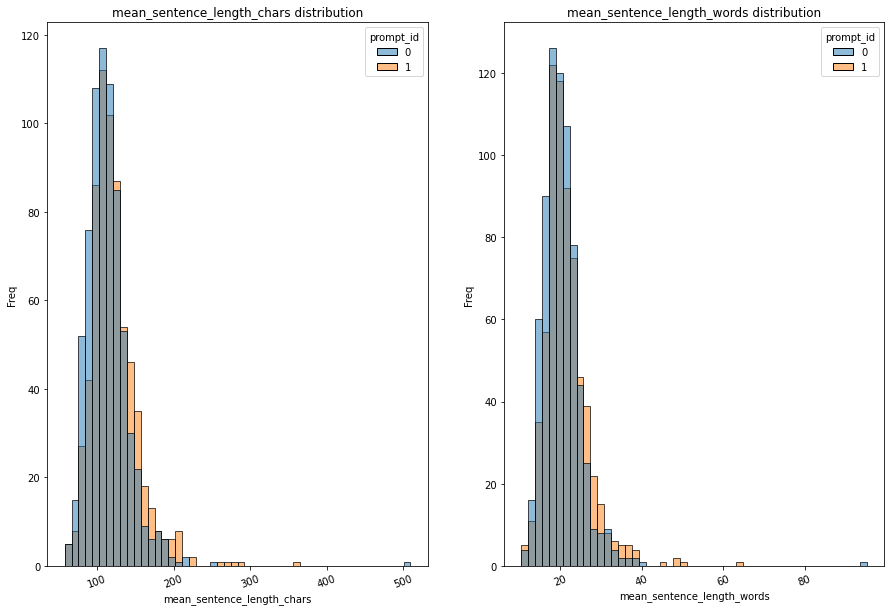

In [133]:
cols = df[['mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), cols):
    sns.histplot(data=df, x=df[col], hue='prompt_id', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

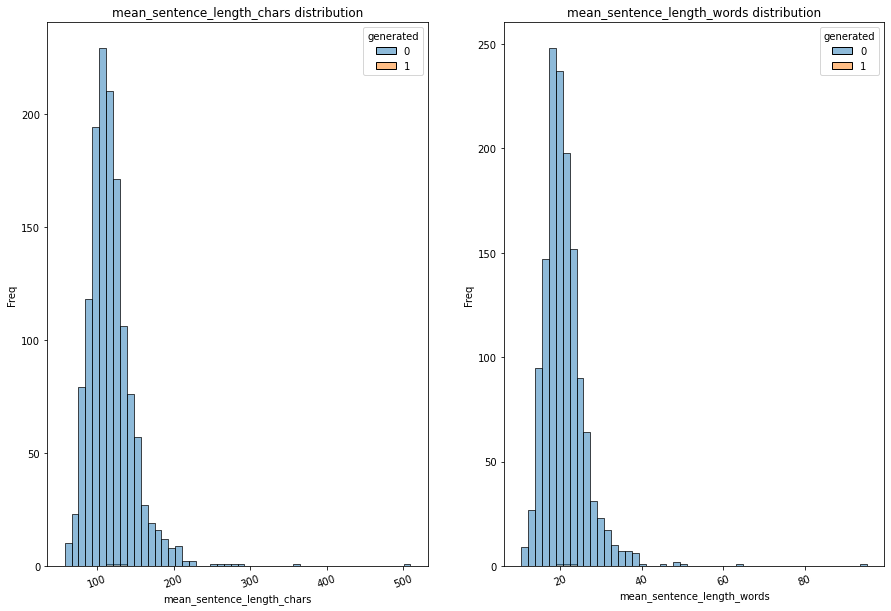

In [134]:
cols = df[['mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)